In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, RNN, Reshape
from tensorflow.keras import Model, Sequential
from keras_model import build_model

In [2]:
df = pd.read_csv('..\\data\\processed2\\processed_data.csv', index_col=0)

In [3]:
df['event_final'] = df['event_final'].astype('category')

In [4]:
df['event_final_code'] = df['event_final'].cat.codes

In [5]:
first = [0]*len(df)
second = [0]*len(df)
third = [0]*len(df)
for i in df.index:
    if isinstance(df.loc[i, '1st runner'], str):
        first[i] = 1
    if isinstance(df.loc[i, '2nd runner'], str):
        second[i] = 1
    if isinstance(df.loc[i, '3rd runner'], str):
        third[i] = 1
    if i % 1000 == 0:
        print(i)
first = np.array(first)
second = np.array(second)
third = np.array(third)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [6]:
df['first'] = first
df['second'] = second
df['third'] = third

In [7]:
situation = df[['inning', 'batting team', 'outs', 'visiting_score', 'home_score', 'first', 'second', 'third']].values
batter = df['res batter'].astype('category').cat.codes.values
pitcher = df['res pitcher'].astype('category').cat.codes.values
balls = df['balls'].values
strikes = df['strikes'].values
fouls = df['fouls'].values
outcome = df['event_final_code'].values
outcome_onehot = pd.get_dummies(df['event_final_code']).values

In [8]:
situation[:, 0] -= 1

In [24]:
class AtBatCell(tf.keras.layers.Layer):

    def __init__(self, n_batters, n_pitchers, situation_size, states):
        super(AtBatCell, self).__init__()
        self.n_batters = n_batters
        self.n_pitchers = n_pitchers
        self.situation_size = situation_size
        self.states = states
        self.state_size = tf.TensorShape([self.n_batters + self.n_pitchers, states])

    def build( self, input_shape ):
        self.Wz = self.add_weight('input z',
                                    shape=[self.states*2, self.situation_size])
        self.Wr = self.add_weight('input r',
                                    shape=[self.states*2, self.situation_size])
        self.Wh = self.add_weight('input h',
                                    shape=[self.states*2, self.situation_size])
        self.Uz = self.add_weight('state z',
                                    shape=[self.states*2, self.states*2])
        self.Ur = self.add_weight('state r',
                                    shape=[self.states*2, self.states*2])
        self.Uh = self.add_weight('state h',
                                    shape=[self.states*2, self.states*2])
        self.bz = self.add_weight('const z',
                                    shape=[self.states*2, 1])
        self.br = self.add_weight('const r',
                                    shape=[self.states*2, 1])
        self.bh = self.add_weight('const h',
                                    shape=[self.states*2, 1])
        super(AtBatCell, self).build(input_shape)
    
    def call(self, inputs, state):
        x, b, p = inputs
        x = tf.reshape(x, (-1, 1))
        state = state[0] + tf.zeros((state[0].shape))
        h = self.get_states(state, b, p)
        hp = self.GRU(x, h)
        state = self.update_states(state, b, p, hp, h)
        state = tf.reshape(state, (1, state.shape[0], state.shape[1]))
        return state, [state]

    def GRU(self, x, h):
        z = self.Wz @ x + self.Uz @ h + self.bz
        z = tf.math.sigmoid(z)
        r = self.Wr @ x + self.Ur @ h + self.br
        r = tf.math.sigmoid(r)
        m = self.Wh @ x + self.Uh @ (r * h) + self.bh
        m = tf.math.tanh(m)
        hp = z * h + (1-z) * m
        return hp

    def get_states(self, states, batter, pitcher):
        state_batter = tf.gather_nd(states[0], batter)
        state_pitcher = tf.gather_nd(states[0], pitcher)
        h = tf.concat((state_batter, state_pitcher), axis=0)
        return tf.reshape(h, (-1, 1))
    
    def update_states(self, states, batter, pitcher, hp, h):
        dh = hp - h
        dh = tf.reshape(dh, (2, -1))
        indices = tf.reshape([batter, pitcher], (2, 1))
        states = states[0] + tf.scatter_nd(indices, dh, states[0].shape)
        return states

class AtBatRNN(RNN):
    
    def __init__(self, n_batters, n_pitchers, situation_size, states, 
                 return_sequences=True, return_state=False,
                 stateful=True, unroll=False):
        self.n_batters = n_batters
        self.n_pitchers = n_pitchers
        self.situation_size = situation_size
        self.states = states
        cell = AtBatCell(n_batters, n_pitchers, situation_size, states)
        super(AtBatRNN, self).__init__(cell, 
            return_sequences=return_sequences, return_state=return_state,
            stateful=stateful, unroll=unroll)
        
    def call(self, inputs, initial_state=None, constants=None):
        return super(AtBatRNN, self).call(inputs, initial_state=initial_state, constants=constants)

In [ ]:
class GameCell(tf.keras.layers.Layer):

    def __init__(self, n_batters, n_pitchers, situation_size, states):
        super(GameCell, self).__init__()
        self.n_batters = n_batters
        self.n_pitchers = n_pitchers
        self.situation_size = situation_size
        self.states = states
        self.state_size = tf.TensorShape([self.n_batters + self.n_pitchers, states])

    def build( self, input_shape ):
        super(GameCell, self).build(input_shape)

    def call(self, inputs, state):
        x, b, p = inputs
        x = tf.reshape(x, (-1, 1))
        state = state[0] + tf.zeros((state[0].shape))
        h = self.get_states(state, b, p)
        hp = self.GRU(x, h)
        state = self.update_states(state, b, p, hp, h)
        state = tf.reshape(state, (1, state.shape[0], state.shape[1]))
        return state, [state]

    def call(self, inputs, state):
        x, b, p = inputs
        x = tf.reshape(x, (-1, 1))
        state = state[0] + tf.zeros((state[0].shape))
        h = self.get_states(state, b, p)
        hp = self.GRU(x, h)
        state = self.update_states(state, b, p, hp, h)
        state = tf.reshape(state, (1, state.shape[0], state.shape[1]))
        return state, [state]

    def GRU(self, x, h):
        z = self.Wz @ x + self.Uz @ h + self.bz
        z = tf.math.sigmoid(z)
        r = self.Wr @ x + self.Ur @ h + self.br
        r = tf.math.sigmoid(r)
        m = self.Wh @ x + self.Uh @ (r * h) + self.bh
        m = tf.math.tanh(m)
        hp = z * h + (1-z) * m
        return hp

    def get_states(self, states, batters, pitchers):
        seq_len = batters.shape[1]
        seq_len_range = tf.expand_dims(tf.range(seq_len, dtype=tf.int32), axis=1)
        batter_indices = tf.concat((seq_len_range, batters[0]),
                                   axis=1)
        pitcher_indices = tf.concat((seq_len_range, pitchers[0]),
                                    axis=1)
        state_batters = tf.gather_nd(states[0], batter_indices)
        state_pitchers = tf.gather_nd(states[0], pitcher_indices)
        h = tf.concat((state_batters, state_pitchers), axis=1)
        return tf.reshape(h, (seq_len, -1, 1))
    
    def update_states(self, states, batter, pitcher, hp, h):
        dh = hp - h
        dh = tf.reshape(dh, (2, -1))
        indices = tf.reshape([batter, pitcher], (2, 1))
        states = states[0] + tf.scatter_nd(indices, dh, states[0].shape)
        return states

class GameRNN(RNN):
    
    def __init__(self, n_batters, n_pitchers, situation_size, states, 
                 return_sequences=True, return_state=False,
                 stateful=True, unroll=False):
        self.n_batters = n_batters
        self.n_pitchers = n_pitchers
        self.situation_size = situation_size
        self.states = states
        cell = GameCell(n_batters, n_pitchers, situation_size, states)
        super(GameRNN, self).__init__(cell, 
            return_sequences=return_sequences, return_state=return_state,
            stateful=stateful, unroll=unroll)
        
    def call(self, inputs, initial_state=None, constants=None):
        return super(GameRNN, self).call(inputs, initial_state=initial_state, constants=constants)

In [25]:
class PredictionLayer(tf.keras.layers.Layer):

    def __init__(self, situation_size, states, classes):
        super(PredictionLayer, self).__init__()
        self.situation_size = situation_size
        self.states = states
        self.classes = classes

    def build( self, input_shape ):
        self.W = self.add_weight('input',
                                   shape=[self.classes, self.situation_size])
        self.U = self.add_weight('state',
                                   shape=[self.classes, self.states*2])
        self.b = self.add_weight('const',
                                   shape=[self.classes, 1])
        super(PredictionLayer, self).build(input_shape)

    def call(self, inputs):
        xp, states, bp, pp = inputs
        xp = tf.expand_dims(xp, axis=-1)
        hp = self.get_states(states, bp, pp)
        return self.W @ xp + self.U @ hp + self.b

    def get_states(self, states, batters, pitchers):
        seq_len = batters.shape[1]
        seq_len_range = tf.expand_dims(tf.range(seq_len, dtype=tf.int32), axis=1)
        batter_indices = tf.concat((seq_len_range, batters[0]),
                                   axis=1)
        pitcher_indices = tf.concat((seq_len_range, pitchers[0]),
                                    axis=1)
        state_batters = tf.gather_nd(states[0], batter_indices)
        state_pitchers = tf.gather_nd(states[0], pitcher_indices)
        h = tf.concat((state_batters, state_pitchers), axis=1)
        return tf.reshape(h, (seq_len, -1, 1))

In [39]:
def build_model( n_batters, n_pitchers, situation_size, states, classes, seq_len, state_model=False ):
    
    '''
    This function builds the tensorflow model.
    '''
    b = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    x = Input(batch_shape=(1, seq_len, situation_size))
    
    h_p = AtBatRNN(n_batters, n_pitchers, situation_size, states)(tuple([x, b, p]))

    if state_model:
        return Model(inputs=[b, p, x],
                     outputs=[h_p])

    print(h_p)
    
    b_p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    p_p = Input(batch_shape=(1, seq_len, 1), dtype=tf.int32)
    x_p = Input(batch_shape=(1, seq_len, situation_size))
    
    result = PredictionLayer(situation_size, states, classes)([x_p, h_p, b_p, p_p])
    
    result = Reshape((seq_len, -1))(result)

    pitch_count = PredictionLayer(situation_size, states, 3)([x_p, h_p, b_p, p_p])
    
    model = Model(inputs=[b, p, x, b_p, p_p, x_p],
                  outputs=[result, pitch_count])
    
    return model

In [40]:
train = range(840000)
test = range(840000, len(df))

In [41]:
seq_len = 16000

In [42]:
seq_start = [len(train)%seq_len + seq_len*i for i in range(len(train)//seq_len)]
time_series = [range(start, start+seq_len) for start in seq_start]
time_series_plus = [range(start+1, start+1+seq_len) for start in seq_start]
time_series_test = [range(len(test))]
time_series_plus_test = [range(1,len(test)+1)]

In [43]:
def convert_to_time_series(tensor, time_series_list):
    tensor_list = []
    for r in time_series_list:
        tensor_list += [tensor[r]]
    return np.stack(tensor_list)

In [44]:
batter_ex = np.expand_dims(batter, axis=1).astype(np.int32)
pitcher_ex = np.expand_dims(pitcher + np.unique(batter).shape[0], axis=1).astype(np.int32)

In [45]:
situation_batched = convert_to_time_series(situation, time_series)
batters_batched = convert_to_time_series(batter_ex, time_series)
pitchers_batched = convert_to_time_series(pitcher_ex, time_series)
situation_batched_plus = convert_to_time_series(situation, time_series_plus)
batters_batched_plus = convert_to_time_series(batter_ex, time_series_plus)
pitchers_batched_plus = convert_to_time_series(pitcher_ex, time_series_plus)

In [46]:
pitch_count = np.concatenate(
    (np.expand_dims(balls, axis=1), np.expand_dims(strikes, axis=1), np.expand_dims(fouls, axis=1)), axis=1
)

In [47]:
pitch_count_batched = convert_to_time_series(pitch_count, time_series_plus)
outcome_onehot_batched = convert_to_time_series(outcome_onehot, time_series_plus)

In [48]:
situation_batched_test = convert_to_time_series(situation, time_series_test)
batters_batched_test = convert_to_time_series(batter_ex, time_series_test)
pitchers_batched_test = convert_to_time_series(pitcher_ex, time_series_test)
situation_batched_plus_test = convert_to_time_series(situation, time_series_plus_test)
batters_batched_plus_test = convert_to_time_series(batter_ex, time_series_plus_test)
pitchers_batched_plus_test = convert_to_time_series(pitcher_ex, time_series_plus_test)

In [49]:
pitch_count_batched_test = convert_to_time_series(pitch_count, time_series_plus_test)
outcome_onehot_batched_test = convert_to_time_series(outcome_onehot, time_series_plus_test)

In [50]:
n_batters = np.unique(batter).shape[0]
n_pitchers = np.unique(pitcher).shape[0]
situation_size = situation.shape[1]
states = 8
classes = outcome_onehot.shape[1]

In [51]:
model = build_model( n_batters, n_pitchers, situation_size, states, classes, seq_len )

ValueError: Unexpectedly found an instance of type `<class 'numpy.ndarray'>`. Expected a symbolic tensor instance.

In [24]:
def compile_model(model, LR):
    adam = tf.keras.optimizers.Adam(lr=LR)
    model.compile(
        optimizer=adam,
        loss=['categorical_crossentropy', 'mean_squared_error'],
        metrics=['accuracy', 'RootMeanSquaredError'])
    return model

In [25]:
model = compile_model(model, 1e-3)
# log_dir = "..\\models\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
for i in range(200):
    print('epoch: '+str(i+1))
    model.reset_states()
    model.fit(x=[batters_batched, pitchers_batched, situation_batched,
                 batters_batched_plus, pitchers_batched_plus, situation_batched_plus],
              y=[outcome_onehot_batched, pitch_count_batched], 
              batch_size=1,
              epochs=1,
              verbose=1)

epoch: 1
Train on 52 samples
52/52 [==============================] - 1939s 37s/sample - loss: 12.7788 - reshape_loss: 8.7464 - prediction_layer_1_loss: 4.0324 - reshape_accuracy: 0.0129 - reshape_RootMeanSquaredError: 1.1319 - prediction_layer_1_accuracy: 0.3977 - prediction_layer_1_RootMeanSquaredError: 2.0081
epoch: 2
Train on 52 samples
52/52 [==============================] - 2122s 41s/sample - loss: 11.4938 - reshape_loss: 8.4625 - prediction_layer_1_loss: 3.0313 - reshape_accuracy: 0.0158 - reshape_RootMeanSquaredError: 1.1531 - prediction_layer_1_accuracy: 0.4082 - prediction_layer_1_RootMeanSquaredError: 1.7411
epoch: 3
Train on 52 samples
52/52 [==============================] - 2167s 42s/sample - loss: 10.6056 - reshape_loss: 8.2848 - prediction_layer_1_loss: 2.3208 - reshape_accuracy: 0.0174 - reshape_RootMeanSquaredError: 1.1545 - prediction_layer_1_accuracy: 0.4208 - prediction_layer_1_RootMeanSquaredError: 1.5234
epoch: 4
Train on 52 samples
 7/52 [===>..................

In [35]:
model.save_weights('..\\models\\prediction_model_v0')

In [36]:
model_test = build_model( n_batters, n_pitchers, situation_size, states, classes, batters_batched_test.shape[1] )
model_test.load_weights('..\\models\\prediction_model_v0')

In [ ]:
state_model = build_model( n_batters, n_pitchers, situation_size, states, classes, batters_batched_test.shape[1], True )
state_model.load_weights('..\\models\\prediction_model_v0')

In [37]:
y_pred = model_test([batters_batched_test.astype(np.int32), pitchers_batched_test.astype(np.int32), 
                situation_batched_test.astype(np.float32), batters_batched_plus_test.astype(np.int32), 
                pitchers_batched_plus_test.astype(np.int32), situation_batched_plus_test.astype(np.float32)])

In [38]:
outcomes_pred = np.squeeze(y_pred[0].numpy())
pitch_count_pred = np.squeeze(y_pred[1].numpy())

In [ ]:
state = state_model([batters_batched_test.astype(np.int32), pitchers_batched_test.astype(np.int32), 
                situation_batched_test.astype(np.float32)])

at_bat_rnn/input z:0


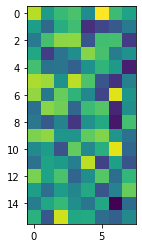

at_bat_rnn/input r:0


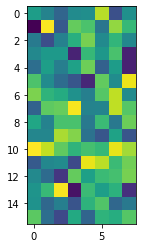

at_bat_rnn/input h:0


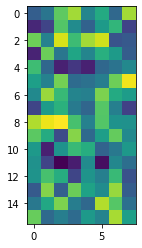

at_bat_rnn/state z:0


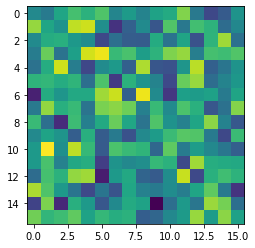

at_bat_rnn/state r:0


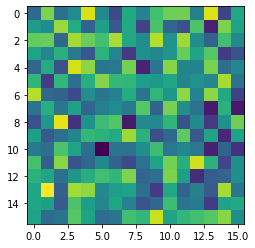

at_bat_rnn/state h:0


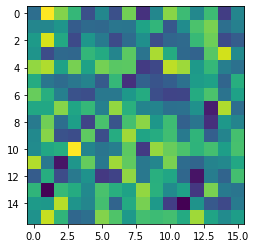

at_bat_rnn/const z:0


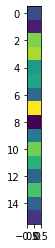

at_bat_rnn/const r:0


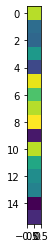

at_bat_rnn/const h:0


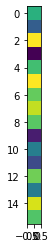

prediction_layer/input:0


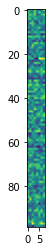

prediction_layer/state:0


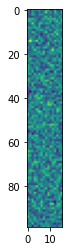

prediction_layer/const:0


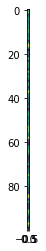

prediction_layer_1/input:0


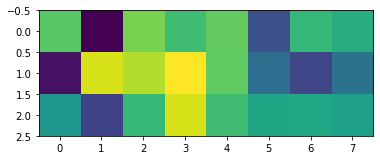

prediction_layer_1/state:0


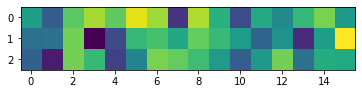

prediction_layer_1/const:0


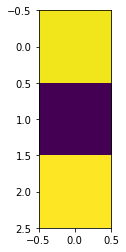

In [39]:
for layer in model.layers:
    for weight in layer.trainable_weights:
        print(weight.name)
        plt.imshow(weight.numpy())
        plt.show()

In [52]:
def get_sit_feed(X, outcome_dict):
    sit_feed = {'inning' : int(round(X[0]) + 1),
                'half inning' : int(round(X[1])),
                'outs' : int(round(X[2])),
                'visiting score' : int(round(X[3])),
                'home score' : int(round(X[4])),
                'first' : int(round(X[5])),
                'second' : int(round(X[6])),
                'third' : int(round(X[7]))}
    return sit_feed

def get_sit_out_test(y_test, ind):
    test = [t[ind] for t in y_test]
    sit_out = {'inning' : np.where(test[0])[0][0]+1,
                'half inning' : int(round(test[1])),
                'outs' : np.where(test[2])[0][0],
                'visiting score' : np.where(test[3])[0][0],
                'home score' : np.where(test[4])[0][0],
                'first' : int(round(test[5])),
                'second' : int(round(test[6])),
                'third' : int(round(test[7]))}
    return sit_out

In [53]:
cats = df['event_final'].astype('category')

outcome_dict = {}
for i, cat in enumerate(cats.cat.categories):
    outcome_dict[cat] = i
outcome_dict_rev = dict(enumerate(cats.cat.categories))
N_outcomes = len(outcome_dict)

In [57]:
ind = -2001
sit_feed = get_sit_feed(situation_batched_test[0, ind], outcome_dict_rev)

In [58]:
sit_feed

{'inning': 5,
 'half inning': 1,
 'outs': 0,
 'visiting score': 2,
 'home score': 2,
 'first': 0,
 'second': 0,
 'third': 0}

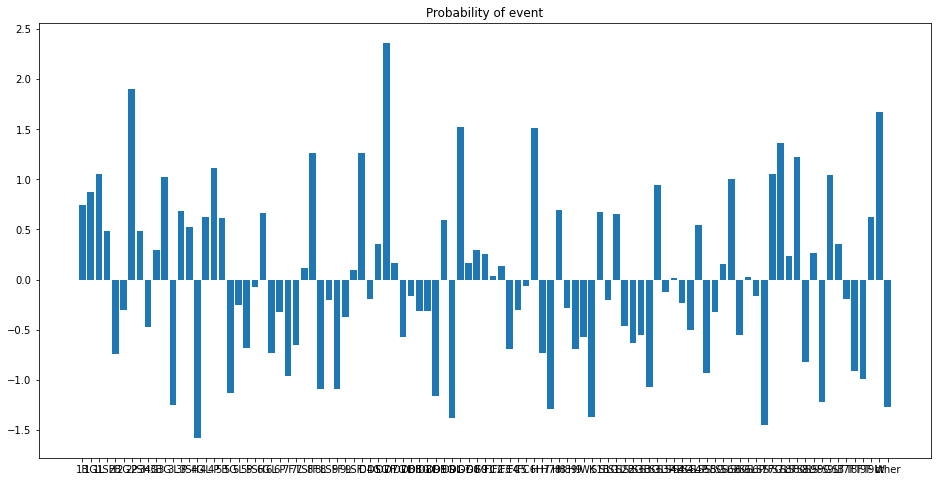

In [62]:
plt.rcParams['figure.figsize'] = 16,8
plt.bar(np.arange(99), outcomes_pred[-5002])
plt.xticks(np.arange(99), list(outcome_dict.keys()))
plt.title('Probability of event')
plt.show()

In [65]:
model_test[:10]

TypeError: 'Model' object is not subscriptable